# Computational biology and bioinformatics - <span style="color:#1CA766">INFO-F-439</span>
# Assignment 1: <span style="color:#1CA766">aligning sequences	and	detecting motifs</span>
  	
  
> ## <span style="color:#2E66A7"> Alberto Parravicini</span>

*****

## <span style="color:#2E66A7">Part 1:</span> implementing the sequence alignment algorithm

### Introduction:

Given two **sequences of aminoacids**, we would like to *align* them to highlight similarities between them. 
In order to do so, we can take inspiration from the famous [**Wagner–Fischer**](https://en.wikipedia.org/wiki/Wagner%E2%80%93Fischer_algorithm) algorithm, used to compute the **edit distance** between two strings.

> <span style="color:#1CA766">**Edit distance:**</span> also known as *Levenshtein distance*, it is the minimum number of characters that have to be inserted, removed or substituted to transform a string into another desired string.

Before tackling the more complex problem of aligning aminoacid sequences, let's build an algorithm to compute the edit distance of 2 strings, as a quick warm-up!

In [105]:
import numpy as np
import editdistance
import utils
import random

def edit_levenshtein(c1, c2):
    """
    Default edit function cost introduced by Levenshtein
    
    Parameters 
    ----------
    c1, c2: any object on which equality is defined.
    
    Returns
    ----------
    int
        0 if c1 == c2 (i.e. no substitution is needed),
        -1 otherwise (i.e. a substitution is needed)
    """
    return 0 if c1 == c2 else 1

First, we define the function that will be used to evaluate the cost of character substitution. 
In the basic Wagner–Fischer algorithm, the cost is **0** if two character are equal, otherwise it is **1**.

More complex models (like the one that we will build for aligning sequences!) will use metrics that keep into account the frequency of characters and how often one character is replaced by another, like in the case of spelling errors (or mutations!).

Below, the full algorithm to compute the edit distance of 2 strings $S^1$ and $S^2$.

If we define $S^1_i,\ S^2_j$ as the substrings of $S^1$ and $S^2$ up to characters $i$ and $j$, the edit distance $d(S^1_i,\ S^2_j)$ will be given by the recursion:

$$
    d(S^1_i,\ S^2_j)=max\left\{
                \begin{array}{ll}
                  d(S^1_{i-1},\ S^2_j) + gap\text{-}penalty\\
                  d(S^1_{i},\ S^2_{j-1}) + gap\text{-}penalty\\
                  d(S^1_{i-1},\ S^2_{j-1}) + edit\text{-}function(i,j)
                \end{array}
              \right.
  $$

In [106]:
def edit_distance(s1, s2, gap_penalty = 1, edit_function = edit_levenshtein):

    """
    Compute the edit distance between 2 strings "s1" and "s2", 
    i.e. the number of character deletions, insertions and substitutions 
    required to turn "s1" into "s2".
    
    Parameters 
    ----------
    s1, s2: array-like
        
    gap_penalty: int, optional
        The penalty factor assigned to character deletions and insertions.
        
    edit_function: function, optional
        The function that is used to compute the cost of a character subtitution.
        
    
    Returns 
    ----------
    int
        The edit distance between s1 and s2
    """
    n_row= len(s1) + 1
    n_col = len(s2) + 1
    edit_matrix = np.zeros((n_row, n_col))
    
    for i in range(n_row):
        edit_matrix[i, 0] = i * gap_penalty
                    
    for j in range(n_col):
        edit_matrix[0, j] = j * gap_penalty
                       
    for i in range(1, n_row):
        for j in range(1, n_col):
            x_gap = edit_matrix[i - 1, j] + gap_penalty
            y_gap = edit_matrix[i, j - 1] + gap_penalty
            mut = edit_matrix[i - 1, j - 1] + edit_function(s1[i - 1], s2[j - 1])
            edit_matrix[i, j] = min(x_gap, y_gap, mut)
    
    return edit_matrix[len(s1), len(s2)]

Note that in the standard algorithm, one considers character deletions and insertions. However, that is in practice equivalent to match the characters that have to be deleted/inserted to a **gap** character (for instance, "**\_**").
Noting this fact will come in handy when dealing with aminoacid sequences!

****

Now, let's test the edit distance!

The first test is taken from [Wikipedia](https://en.wikipedia.org/wiki/Edit_distance#Example), while the second evaluates the edit distance of 100 pairs randomly generated strings, and compares the results with the ones computed by the Python [editdistace](https://pypi.python.org/pypi/editdistance) package (if you don't have it installed, I promise you that the algorithm works well!)

In [107]:
print(edit_distance("kitten", "sitting"))

min_string_size = 20
max_string_size = 70
# Perform a quick test to see if the edit distance is ok!
n_test = 100
for _ in range(n_test):
    s1 = utils.generate_string(random.randint(min_string_size, max_string_size), utils.aminoacid_list)
    s2 = utils.generate_string(random.randint(min_string_size, max_string_size), utils.aminoacid_list)
    assert edit_distance(s1, s2) == editdistance.eval(s1, s2), "Edit distance is wrong!"

3.0


****

### <span style="color:#1CA766">Needleman-Wunsch</span> algorithm for global alignment:

Enough with this simple stuff, let's now see something a bit fancier! 
In this section, we'll see how to **globally** align 2 aminoacid sequences, i.e. find the best way to match the sequences by keeping into account all the aminoacids that compose them.
To do so, we will implement the so-called **Needleman-Wunsch** algorithm.

The basic version of the **Needleman-Wunsch** algorithm is *very* similar to the Wagner–Fischer algorithm. The major difference is that the cost for substituting 2 characters (which are aminoacids, in our case) is no longer fixed, but it depends on the aminoacids that are considered. 
In short, it could happen that in a sequence an aminoacid is replaced by another, due to random mutations or other factors.
Some mutations are more frequent than others, though! 

Based on the empirical probability to observe a certain mutation in nature, biologist have built a number of **substitution matrices**, which intuitively express the *distance* between a pair of given aminoacids.

In the following implementation, these matrices are provided by the Pytohn package [BioPython](https://biopython.org/wiki/Biopython).

Note that the matrices are implemented as hash tables, so to access the substitution value of an aminoacid pair **(c1, c2)** it is necessary to try both **(c1, c2)** and **(c2, c1)** as potential keys of the table!


In [108]:
import numpy as np
from Bio import SeqIO, pairwise2
from Bio.SubsMat import MatrixInfo
import utils
import random
import pandas as pd

import timeit

def sub_matrices_distance(c1, c2, matrix=MatrixInfo.pam120):
    """
    Get the substitution score for c1 and c2 
    according to the provided substitution matrix.

    Parameters
    ----------
    c1, c2: char

    matrix: Bio.SubsMat.MatrixInfo.available_matrix, optional
        The substitution matrix to be used, among the ones available in Bio.SubsMat.MatrixInfo

    Returns 
    ----------
    int  
        the score for substituting c1 with c2.
    """
    return matrix[(c1, c2)] if (c1, c2) in matrix else matrix[(c2, c1)]

Now, let's see a first version of the **Needleman-Wunsch** algorithm.
The algorithm returns the alignment score of the 2 input sequences, and the matrix that contains the partial alignment scores.
This matrix can then be used to rebuild the aligmnent itself, as shown later.

The structure of the algorithm is the same as **Wagner–Fischer**, but in this case we allow for **semiglobal** alignments:
this means that adding gaps at the start of the alignment is not penalized; if the semiglobal alignment isn't used, the algorithm would tend to prefer alignments without gaps at the beginning, in which the sequences are perfectly aligned at the start.

The core of the algorithm is in the recurrence relation used to define the alignment score:

If we define $S^1_i,\ S^2_j$ as the sequences of $S^1$ and $S^2$ up to aminoacid $i$ and $j$, the alignment score $d(S^1_i,\ S^2_j)$ will be given by the recursion:

$$
    d(S^1_i,\ S^2_j)=max\left\{
                \begin{array}{ll}
                  d(S^1_{i-1},\ S^2_j) + gap\text{-}penalty\\
                  d(S^1_{i},\ S^2_{j-1}) + gap\text{-}penalty\\
                  d(S^1_{i-1},\ S^2_{j-1}) + substitution\text{-}cost(i,j)
                \end{array}
              \right.
  $$
  
Note that the first row and column of the alignment matrix are initialized differently.

In the standard version, we have:
$$d(S^1_i,\ S^2_j) = i \cdot gap\text{-}penalty,\ if\ j=0$$
$$d(S^1_i,\ S^2_j) = j \cdot gap\text{-}penalty,\ if\ i=0$$

In the semiglobal version, they all have value $0$.

In [109]:
def global_aligner(s1, s2, gap_penalty = -1, edit_function=sub_matrices_distance, matrix=MatrixInfo.pam120, semiglobal=False):
    """
    Compute the global alignment between 2 aminoacid sequences "s1" and "s2".
    
    Parameters 
    ----------
    s1, s2: string
        The two input aminoacid sequences on which the edit distance is computed.
        
    gap_penalty: int, optional
        The penalty factor assigned to matching an aminoacid to a gap character.
        It should be a NEGATIVE integer.
        
    edit_function: function, optional
        The function that is used to compute the cost of an aminoacid subtitution.
        
    matrix: Bio.SubsMat.MatrixInfo.available_matrix, optional
        The substitution matrix to be used, among the ones available in Bio.SubsMat.MatrixInfo.
        It is used by edit_function, if needed.
        
    semiglobal: bool
        Set to false to penalize the sequences for not being aligned at the start.
        If true, don't penalize gaps at the beginning of the alignment.

    Returns 
    ----------
    int
        The edit distance between s1 and s2
    
    float64 np.matrix
        The alignment matrix of s1 and s2
    """
    n_row= len(s1) + 1
    n_col = len(s2) + 1
    edit_matrix = np.zeros((n_row, n_col))
    
    for i in range(n_row):
        edit_matrix[i, 0] = i * (0 if semiglobal else gap_penalty)
                    
    for j in range(n_col):
        edit_matrix[0, j] = j * (0 if semiglobal else gap_penalty)
                       
    for i in range(1, n_row):
        for j in range(1, n_col):
            s1_gap = edit_matrix[i - 1, j] + gap_penalty
            s2_gap = edit_matrix[i, j - 1] + gap_penalty
            mut = edit_matrix[i - 1, j - 1] + edit_function(s1[i - 1], s2[j - 1], matrix=matrix)
            edit_matrix[i, j] = max(s1_gap, s2_gap, mut)
            
    # If semiglobal alignment, get the best value on the last row.
    align_score = max(edit_matrix[len(s1), :]) if semiglobal else edit_matrix[len(s1), len(s2)]
    return [align_score, edit_matrix]

Let's test the algorithm by aligning a few pairs of sequences.
The first pair is the same seen in the [lectures](http://www.ulb.ac.be/di/map/tlenaert/Home_Tom_Lenaerts/INFO-F-439_files/aligning%20sequences.pdf), and in this case the alignment matrix is also printed, as a further check.
In this simple case the algorithm is tested with in the standard and semiglobal version.

The second pair is composed of proteins <span style="color:#1CA766">**>sp|P46937|YAP1_HUMAN Transcriptional coactivator YAP1 OS=Homo sapiens GN=YAP1 PE=1 SV=2**</span> and <span style="color:#2E66A7">**>sp|P46934|NEDD4_HUMAN E3 ubiquitin-protein ligase NEDD4 OS=Homo sapiens GN=NEDD4 PE=1 SV=4**</span>.

Once again, the algorithm is tested both in the standard and semiglobal version.
In this case, the results of the alignment are compared to [LALIGN](http://www.ch.embnet.org/software/LALIGN_form.html), and both algorithms give the same scores!

Unfortunately it isn't possible to link the result page of LALIGN, but the aligner was run with the following parameters:
* **Alignment method**: global & global without end-gap penalty (i.e. semiglobal)
* **E-value threshold**: 0
* **Scoring matrix**: BLOSUM62
* **Opening gap penalty**: 0
* **Extending gap penalty**: -1 

In [110]:
s1 = "THISLINE"
s2 = "ISALIGNED"
[score, align_matrix] = global_aligner(s1, s2, gap_penalty=-4, matrix=MatrixInfo.blosum62, semiglobal=False)

print(align_matrix)
print(score)

[[  0.  -4.  -8. -12. -16. -20. -24. -28. -32. -36.]
 [ -4.  -1.  -3.  -7. -11. -15. -19. -23. -27. -31.]
 [ -8.  -5.  -2.  -5.  -9. -13. -17. -18. -22. -26.]
 [-12.  -4.  -6.  -3.  -3.  -5.  -9. -13. -17. -21.]
 [-16.  -8.   0.  -4.  -5.  -5.  -5.  -8. -12. -16.]
 [-20. -12.  -4.  -1.   0.  -3.  -7.  -8. -11. -15.]
 [-24. -16.  -8.  -5.   1.   4.   0.  -4.  -8. -12.]
 [-28. -20. -12.  -9.  -3.   0.   4.   6.   2.  -2.]
 [-32. -24. -16. -13.  -7.  -4.   0.   4.  11.   7.]]
7.0


In [111]:
s1 = "THISLINE"
s2 = "ISALIGNED"
[score, align_matrix] = global_aligner(s1, s2, gap_penalty=-8, matrix=MatrixInfo.blosum62, semiglobal=True)

print(align_matrix)
print(score)

[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.  -1.   1.   0.  -1.  -1.  -2.   0.  -1.  -1.]
 [  0.  -3.  -2.  -1.  -3.  -4.  -3.  -1.   0.  -2.]
 [  0.   4.  -4.  -3.   1.   1.  -7.  -6.  -4.  -3.]
 [  0.  -2.   8.   0.  -5.  -1.   1.  -6.  -6.  -4.]
 [  0.   2.   0.   7.   4.  -3.  -5.  -2.  -9. -10.]
 [  0.   4.   0.  -1.   9.   8.   0.  -8.  -5. -12.]
 [  0.  -3.   5.  -2.   1.   6.   8.   6.  -2.  -4.]
 [  0.  -3.  -3.   4.  -4.  -2.   4.   8.  11.   3.]]
11.0


In [112]:
long_s1 = "MDPGQQPPPQPAPQGQGQPPSQPPQGQGPPSGPGQPAPAATQAAPQAPPAGHQIVHVRGD" \
+ "SETDLEALFNAVMNPKTANVPQTVPMRLRKLPDSFFKPPEPKSHSRQASTDAGTAGALTP" \
+ "QHVRAHSSPASLQLGAVSPGTLTPTGVVSGPAATPTAQHLRQSSFEIPDDVPLPAGWEMA" \
+ "KTSSGQRYFLNHIDQTTTWQDPRKAMLSQMNVTAPTSPPVQQNMMNSASGPLPDGWEQAM" \
+ "TQDGEIYYINHKNKTTSWLDPRLDPRFAMNQRISQSAPVKQPPPLAPQSPQGGVMGGSNS" \
+ "NQQQQMRLQQLQMEKERLRLKQQELLRQAMRNINPSTANSPKCQELALRSQLPTLEQDGG" \
+ "TQNPVSSPGMSQELRTMTTNSSDPFLNSGTYHSRDESTDSGLSMSSYSVPRTPDDFLNSV" \
+ "DEMDTGDTINQSTLPSQQNRFPDYLEAIPGTNVDLGTLEGDGMNIEGEELMPSLQEALSS" \
+ "DILNDMESVLAATKLDKESFLTWL"
long_s2 = "MAQSLRLHFAARRSNTYPLSETSGDDLDSHVHMCFKRPTRISTSNVVQMKLTPRQTALAP" \
+ "LIKENVQSQERSSVPSSENVNKKSSCLQISLQPTRYSGYLQSSNVLADSDDASFTCILKD" \
+ "GIYSSAVVDNELNAVNDGHLVSSPAICSGSLSNFSTSDNGSYSSNGSDFGSCASITSGGS" \
+ "YTNSVISDSSSYTFPPSDDTFLGGNLPSDSTSNRSVPNRNTTPCEIFSRSTSTDPFVQDD" \
+ "LEHGLEIMKLPVSRNTKIPLKRYSSLVIFPRSPSTTRPTSPTSLCTLLSKGSYQTSHQFI" \
+ "ISPSEIAHNEDGTSAKGFLSTAVNGLRLSKTICTPGEVRDIRPLHRKGSLQKKIVLSNNT" \
+ "PRQTVCEKSSEGYSCVSVHFTQRKAATLDCETTNGDCKPEMSEIKLNSDSEYIKLMHRTS" \
+ "ACLPSSQNVDCQININGELERPHSQMNKNHGILRRSISLGGAYPNISCLSSLKHNCSKGG" \
+ "PSQLLIKFASGNEGKVDNLSRDSNRDCTNELSNSCKTRDDFLGQVDVPLYPLPTENPRLE" \
+ "RPYTFKDFVLHPRSHKSRVKGYLRLKMTYLPKTSGSEDDNAEQAEELEPGWVVLDQPDAA" \
+ "CHLQQQQEPSPLPPGWEERQDILGRTYYVNHESRRTQWKRPTPQDNLTDAENGNIQLQAQ" \
+ "RAFTTRRQISEETESVDNRESSENWEIIREDEATMYSNQAFPSPPPSSNLDVPTHLAEEL" \
+ "NARLTIFGNSAVSQPASSSNHSSRRGSLQAYTFEEQPTLPVLLPTSSGLPPGWEEKQDER" \
+ "GRSYYVDHNSRTTTWTKPTVQATVETSQLTSSQSSAGPQSQASTSDSGQQVTQPSEIEQG" \
+ "FLPKGWEVRHAPNGRPFFIDHNTKTTTWEDPRLKIPAHLRGKTSLDTSNDLGPLPPGWEE" \
+ "RTHTDGRIFYINHNIKRTQWEDPRLENVAITGPAVPYSRDYKRKYEFFRRKLKKQNDIPN" \
+ "KFEMKLRRATVLEDSYRRIMGVKRADFLKARLWIEFDGEKGLDYGGVAREWFFLISKEMF" \
+ "NPYYGLFEYSATDNYTLQINPNSGLCNEDHLSYFKFIGRVAGMAVYHGKLLDGFFIRPFY" \
+ "KMMLHKPITLHDMESVDSEYYNSLRWILENDPTELDLRFIIDEELFGQTHQHELKNGGSE" \
+ "IVVTNKNKKEYIYLVIQWRFVNRIQKQMAAFKEGFFELIPQDLIKIFDENELELLMCGLG" \
+ "DVDVNDWREHTKYKNGYSANHQVIQWFWKAVLMMDSEKRIRLLQFVTGTSRVPMNGFAEL" \
+ "YGSNGPQSFTVEQWGTPEKLPRAHTCFNRLDLPPYESFEELWDKLQMAIENTQGFDGVD"
[score_1, _] = global_aligner(long_s1, long_s2, gap_penalty=-1, matrix=MatrixInfo.blosum62, semiglobal=False)
[score_2, _] = global_aligner(long_s1, long_s2, gap_penalty=-1, matrix=MatrixInfo.blosum62, semiglobal=True)

print("My aligner, semiglobal = False -- score_1:", score_1)
print("Semiglobal = True -- score_2:", score_2)

My aligner, semiglobal = False -- score_1: 666.0
Semiglobal = True -- score_2: 842.0


For comparison, the results given by LALIGN are:
> **Global:** (it doesn't provide any alignment! Using other sequences from the same file also doesn't seem to work, not even with sightly different parameters).  
> **Semiglobal:** global/local score: 842; 26.3% identity (42.3% similar) in 834 aa overlap (1-504:587-1305)


***

What if we want to recover the alignment of the 2 sequences, instead of just the scores?
A first approach is to start from the final cell, and recompute the moves that brought us there. Then we select the right move, and repeat until the start of the sequences is found.

With this approach is however possible to find just 1 alignment, as in case of equal scores just 1 will be chosen.
However, if we don't need more equivalent alignments, this approach is quite fast!

In [113]:
def backtrack_matrix_1(s1, s2, input_matrix, gap_penalty=-1, edit_function=sub_matrices_distance, matrix=MatrixInfo.pam120, semiglobal=False):
    i = len(s1)
    j = len(s2) 
    aligned_s1 = ""
    aligned_s2 = ""    
    match_sequence = ""
      
    while i > 0 or j > 0:
        val = input_matrix[i, j]
        s1_gap = input_matrix[i - 1, j] + (0 if (semiglobal == True and j == 0) else gap_penalty)
        s2_gap = input_matrix[i, j - 1] + (0 if (semiglobal == True and i == 0) else gap_penalty)
        mut = input_matrix[i - 1, j - 1] + edit_function(s1[i - 1], s2[j - 1], matrix=matrix)

        # Match s1 to a gap, move vertically
        if i > 0 and val == s1_gap:
            aligned_s1 = s1[i - 1] + aligned_s1
            aligned_s2 = "-" + aligned_s2
            match_sequence = " " + match_sequence
            i -= 1
        # Match s2 to a gap, move horizontally
        elif j > 0 and val == s2_gap:
            aligned_s1 = "-" + aligned_s1
            aligned_s2 = s2[j - 1] + aligned_s2
            match_sequence = " " + match_sequence
            j -= 1
        # Substitution, diagonal movement
        elif i > 0 and j > 0 and val == mut:
            aligned_s1 = s1[i - 1] + aligned_s1
            aligned_s2 = s2[j - 1] + aligned_s2
            match_sequence = (":" if s1[i - 1] == s2[j - 1] else ".") + match_sequence
            i -= 1
            j -= 1
        else:
            raise ValueError("val={0}, but we have s1_gap={1}, s2_gap={2}, mut={3}".format(val, s1_gap, s2_gap, mut))

    return [aligned_s1, aligned_s2, match_sequence]

Let's now find the alignments of the previous pairs of sequences, and also of the WW sequences provided in the file "WW-sequence.fasta". 

The results are compared to the ones found by the aligner provided by BioPython; however it was not possible to configure this alignment with exactly the same settings used by our algorithm, and as such the alignment scores given by BioPython are sightly higher.

In [114]:
# Load the sequences and test their edit distance
start_time = timeit.default_timer()

for i, seq_record_i in enumerate(SeqIO.parse("../data/WW-sequence.fasta", "fasta")):
   for j, seq_record_j in enumerate(SeqIO.parse("../data/WW-sequence.fasta", "fasta")):
       if i > j :
            print("Comparing:\n\t", seq_record_i.id, "-- length:", len(seq_record_i))
            print("\t", seq_record_j.id, "-- length:", len(seq_record_j), "\n")
            [score, edit_matrix] = global_aligner(seq_record_i.seq,  seq_record_j.seq, gap_penalty=-1, matrix=MatrixInfo.blosum62)
            [s1_al, s2_al, match_sequence] = backtrack_matrix_1(seq_record_i.seq, seq_record_j.seq, edit_matrix, gap_penalty=-1, matrix=MatrixInfo.blosum62)
            
            print("\nMY ALIGNER:")
            print(s1_al)
            print(match_sequence)
            print(s2_al)
            print("  Score=", score, "\n", sep="")
            biopython_align = pairwise2.align.globaldx(seq_record_i.seq, seq_record_j.seq, MatrixInfo.blosum62, score_only = False, one_alignment_only=True)
            print("BIOPYTHON ALIGNER:\n", pairwise2.format_alignment(*biopython_align[0]), sep="")
            print("--------------------------------------\n")
end_time = timeit.default_timer()
print("! -> EXECUTION TIME:", (end_time - start_time), "\n")

Comparing:
	 sp|P46934|610-643 -- length: 34
	 sp|P46937|171-204 -- length: 34 


MY ALIGNER:
-SPLPPGWE-ER-QDILG-RTYYVNH-ESRRTQWK-RPTP
  :::.::: .. ..  : : :..:: . ..:.:.  :..
V-PLPAGWEMAKTSS--GQR-YFLNHID-QTTTWQD-PRK
  Score=87.0

BIOPYTHON ALIGNER:
S-PLPP-GWEERQDIL-----G-RTYYVNH-ESRRTQ--WKRPT-P--
||||||||||||||||||||||||||||||||||||||||||||||||
-VPL-PAGW-E----MAKTSSGQR-YFLNHID--QT-TTW-Q--DPRK
  Score=105

--------------------------------------

Comparing:
	 sp|P46934|892-925 -- length: 34
	 sp|P46937|171-204 -- length: 34 


MY ALIGNER:
-GPLPPGWE-ERTHTDG-RIFYINHNIKRTQ-WEDPR-L
  :::.::: ..: ..: : ...:: :..:. :.:::  
V-PLPAGWEMAKT-SSGQR-YFLNH-IDQTTTWQDPRK-
  Score=108.0

BIOPYTHON ALIGNER:
G-PLPP-GWEE--RTHTD-G-RIFY-INHNIK-RTQ--WEDPRL-
|||||||||||||||||||||||||||||||||||||||||||||
-VPL-PAGW-EMAKT-S-SGQR--YFLNH-I-DQT-TTWQDPR-K
  Score=123

--------------------------------------

Comparing:
	 sp|P46934|892-925 -- length: 34
	 sp|P46934|610-643 -- length: 34 


MY ALIGNER:
GPLPPGWEERTHTD--G

As a quick check,the first 2 pairs are also aligned using LALIGN, using the same setting specified before.
It can be seen that the alignments are sightly different, but the scores are the same.

In the next section we will see how to get more equivalent alignment, so it will be possible to find the same alignments produced by LALIGN.


>global/global (N-W) score: 87; 35.0% identity (55.0% similar) in 40 aa overlap (1-34:1-34)

>V-PLPAGWEMAKTSS--GQR-YFLNHID-QTTTWQD-PRK  

>::: :::  . ..  : : :..:: . . : :.  :  

>SPLPPGWE-ER-QDILG-RTYYVNH-ESRRTQWK-RPTP

*** 

> global/global (N-W) score: 108; 43.6% identity (64.1% similar) in 39 aa overlap (1-34:1-34)

>V-PLPAGWEMAKT-SSGQR-YFLNH-IDQTTTWQDPR-K

>::: :::  .: ..: : ...:: : .:  :.:::  

>-GPLPPGWE-ERTHTDG-RIFYINHNIKRTQ-WEDPRL-
           



    
 

***

Can we make our algorithm even better? It would be nice to find more equivalent alignments (i.e. with the same score), and to use **affine gap penalty** to penalize alignments with many small gaps.

In this section we will see how to extend the previous algorithm to do so!

### <span style="color:#1CA766">Finding more alignments:</span>

Below, a modified version of the previous aligner. 

Now, the backtracking to find the alignments will be done by using a matrix (technically, a **pandas.DataFrame**) that contains, for each cell, the optimal move that lead to that cell. In case one cell can be reached with more optimal moves, all of them are listed. This will allow to recover all the equivalent optimal alignments!

In [181]:
def global_aligner_2(s1, s2, gap_penalty=-1, edit_function=utils.sub_matrices_distance, matrix=MatrixInfo.pam120, semiglobal=False):
    """
    Compute the global alignment between 2 aminoacid sequences "s1" and "s2".

    Parameters 
    ----------
    s1, s2: string
        The two input aminoacid sequences on which the edit distance is computed.

    gap_penalty: int, optional
        The penalty factor assigned to matching an aminoacid to a gap character.
        It should be a NEGATIVE integer.

    edit_function: function, optional
        The function that is used to compute the cost of an aminoacid subtitution.

    matrix: Bio.SubsMat.MatrixInfo.available_matrix, optional
        The substitution matrix to be used, among the ones available in Bio.SubsMat.MatrixInfo.
        It is used by edit_function, if needed.

    semiglobal: bool
        Set to false to penalize the sequences for not being aligned at the start.
        If true, don't penalize gaps at the beginning of the alignment.

    Returns 
    ----------
    int
        The alignment score of s1 and s2

    float64 np.matrix
        The alignment matrix of s1 and s2

    pandas.DataFrame
        The backtrack matrix, which shows the optimal matching "movements" for each cell.
    """
    n_row = len(s1) + 1
    n_col = len(s2) + 1
    # Creates a matrix where the partial scores are stored.
    edit_matrix = np.zeros((n_row, n_col))
    # Creates a matrix (stored as DataFrame) where the optimal movements are
    # stored.
    backtrack_matrix = pd.DataFrame("", index=np.arange(n_row), columns=np.arange(n_col))

    # Initialize the first column and row of the matrices.
    for i in range(n_row):
        edit_matrix[i, 0] = i * (0 if semiglobal else gap_penalty)
        backtrack_matrix.set_value(i, 0, "V")

    for j in range(n_col):
        edit_matrix[0, j] = j * (0 if semiglobal else gap_penalty)
        backtrack_matrix.set_value(0, j, "H")

    # Set the first cell of the backtrack matrix to "X", as an end-marker.
    backtrack_matrix.set_value(0, 0, "X")

    for i in range(1, n_row):
        for j in range(1, n_col):
            # Compute the possible movements, and then keeps the best.
            s1_gap = edit_matrix[i - 1, j] + gap_penalty
            s2_gap = edit_matrix[i, j - 1] + gap_penalty
            mut = edit_matrix[i - 1, j - 1] + edit_function(s1[i - 1], s2[j - 1], matrix=matrix)
            edit_matrix[i, j] = max(s1_gap, s2_gap, mut)

            # Write in the matrix the movement that lead to that cell, as a string.
            # e.g. "HV" means that horizontal and vertical movements were the
            # best.
            backtrack_matrix.set_value(i, j, "".join(check_argmax([s1_gap, s2_gap, mut])))
    
    # If semiglobal alignment, get the best value on the last row.
    align_score = max(edit_matrix[len(s1), :]) if semiglobal else edit_matrix[len(s1), len(s2)]
    return [align_score, edit_matrix, backtrack_matrix]


**check_argmax** is a support function used by the previous algorithm. It will return which movements lead us to a given cell, given an array containing the 3 scores of the moves relative to that cell. 

In [182]:
from itertools import compress

def check_argmax(array):
    """
    Checks which movements are the best, given an array containing 3 scores. 

    Parameters
    ----------
    array: array-like
        numerical array of size 3, it contains the scores relative to character insertion/deletion/subtitution

    Returns
    ----------
    string
        A string of 1 to 3 chars from "V, H, D": a character appears in the return string
        if it is an optimal movement, with maximum score.
    """
    # Check which movements are the best, return it as a list where 1 = max of the list.
    res = [1 if i == max(array) else 0 for i in array]
    return list(compress(["V", "H", "D"], res))

To make things a bit simpler, and more elegant, a class called **Alignment** was created.
It contains the aligned sequences, and optionally the score of the alignment.

In [183]:
class Alignment:
    """
    Class used to store an alignment of 2 sequences, stored as s1 and s2. 
    It also contains a matching string, where for each aminoacid in s1 and s2, we have:\n
        ":" Perfect match of aminoacids.\n
        "." A substitution/mutation occured.\n
        " " A gap was introduced.
    It is possible to add the score of the alignment, if available.
    """

    def __init__(self, s1="", s2="", match="", score=0):
        self.s1 = str(s1)
        self.s2 = str(s2)
        self.match = match
        self.score = 0
    
    def __add__(self, other):
        if isinstance(other, self.__class__):
            return Alignment(s1 = self.s1 + other.s1, s2 = self.s2 + other.s2, match = self.match + other.match)
        return NotImplemented

    def __iadd__(self, other):
        if isinstance(other, self.__class__):
            self.s1 += other.s1
            self.s2 += other.s2
            self.match += other.match
        else:
             return NotImplemented

    def __str__(self):
        return self.s1 + "\n" + self.match + "\n" + self.s2 + "\n\n----- SCORE:" + str(self.score)

    def __repr__(self):
        return str(self)
    


The following function is used to recreate the optimal aligmnents, given the matrix that contains all the movements.

The function is recursively applied to increasingly smaller portions of the matrix, until a starting cell is found.
Starting cells are marked with "X". In the standard case, just the cell (0,0) is marked with "X", while in the case of the semiglobal alignment both the first row and column are marked with "X".

In [184]:
def backtrack_sequence_rec(s1, s2, backtrack_matrix, k=1):
    """
    Given 2 strings s1 and s2, and a backtrack matrix produced by the global aligner, finds k optimal alignments. 

    Parameters
    ----------
    s1, s2: string
        The 2 strings to be aligned. 
    
    backtrack_matrix: pandas.DataFrame
        Matrix containing the best movements, produced by the global aligner applied to s1 and s2. 
    
    k: int, optional
        The number of best alignment to return, in case there are more alignments with the same optimal score.

    Returns
    ----------    
    array of Alignment
        A list of k alignments, of class utils.Alignment
    """
    i = len(s1)
    j = len(s2)

    align_list = []

    try:
        # For all the possible moves in a cell, in case there's more than 1.
        for mov in backtrack_matrix.iloc[i, j]:
            # Only if we don't already have k sequences, so we don't waste time.
            if len(align_list) < k:
                # For each move, we apply recursively the backtraking to a subset of the matrix,
                # and at the end append the current matching, if we have less than k alignments.
                if mov == "V":
                    for align_i in backtrack_sequence_rec(s1[:i - 1], s2[:j], backtrack_matrix.iloc[:i, :j + 1], k=k):
                        if len(align_list) < k:
                            align_list.append(
                                align_i + utils.Alignment(s1[i - 1], "-", " "))
                        else: break

                elif mov == "H":
                    for align_i in backtrack_sequence_rec(s1[:i], s2[:j - 1], backtrack_matrix.iloc[:i + 1, :j], k=k):
                        if len(align_list) < k:
                            align_list.append(
                                align_i + utils.Alignment("-", s2[j - 1], " "))
                        else: break

                elif mov == "D":
                    for align_i in backtrack_sequence_rec(s1[:i - 1], s2[:j - 1], backtrack_matrix.iloc[:i, :j], k=k):
                        if len(align_list) < k:
                            align_list.append(
                                align_i + utils.Alignment(s1[i - 1], s2[j - 1],  (":" if s1[i - 1] == s2[j - 1] else ".")))
                        else: break
                # End of the recursion, stop if we reach the first cell.
                elif mov == "X":
                    return [utils.Alignment("", "", "")]

                else: raise ValueError("val={0} isn't a valid movement!".format(mov))
    except IndexError:
        print("i:", i, " -- j:", j)
        raise

    return align_list

In case the algorithm is used in semiglobal mode, a small tweak to the backtracking function is required, so that we don't lose the beginning of the aligned sequences once the first row or column is reached.

In [185]:
def semiglobal_backtrack(s1, s2, score_matrix, backtrack_matrix, k=1):
    """
    Backtrack function used for semiglobal alignments.
    Given 2 strings s1 and s2, and a backtrack matrix produced by the global aligner, finds k optimal alignments. 

    Parameters
    ----------
    s1, s2: string
        The 2 strings to be aligned. 
    
    backtrack_matrix: pandas.DataFrame
        Matrix containing the best movements, produced by the global aligner applied to s1 and s2. 
    
    k: int, optional
        The number of best alignment to return, in case there are more alignments with the same optimal score.

    Returns
    ----------    
    array of Alignment
        A list of k alignments, of class utils.Alignment
    """
    # Find where the maximum score is, in the last row of the matrix.
    j_max = np.argmax(score_matrix[len(s1), :])
    # Apply backtracking only to the relevant part of the matrix.
    align_list = backtrack_sequence_rec(s1, s2[:j_max], backtrack_matrix.iloc[:, :j_max+1], k)
    # Append the remaining part of the sequence to the end
    align_list = [align_i + utils.Alignment("-" * (len(s2) - j_max), s2[j_max:], " "* (len(s2) - j_max)) for align_i in align_list]
    return align_list

The new version of the algorithm is tested again against the WW sequences.

Note how slower this version is compared to the previous one!
This is mainly due to the creation of the DataFrame, and suprisingly the recursive backtrack doesn't take much time at all (it is still slower than the previous version, though)!

In [186]:
# Load the sequences and test their edit distance
start_time = timeit.default_timer()

for i, seq_record_i in enumerate(SeqIO.parse("../data/WW-sequence.fasta", "fasta")):
   for j, seq_record_j in enumerate(SeqIO.parse("../data/WW-sequence.fasta", "fasta")):
       if i > j :
            print("Comparing:\n\t", seq_record_i.id, "-- length:", len(seq_record_i))
            print("\t", seq_record_j.id, "-- length:", len(seq_record_j), "\n")
            [score, edit_matrix, backtrack_matrix] = global_aligner_2(seq_record_i.seq,  seq_record_j.seq, gap_penalty=-1, matrix=MatrixInfo.blosum62)
            alignments = backtrack_sequence_rec(seq_record_i.seq, seq_record_j.seq, backtrack_matrix, k = 3)
                  
            print("\nMY ALIGNER:")
            for align_i in alignments: 
                align_i.score = score 
                print(align_i)
            biopython_align = pairwise2.align.globaldx(seq_record_i.seq, seq_record_j.seq, MatrixInfo.blosum62, score_only = False, one_alignment_only=True)
            print("\nBIOPYTHON ALIGNER:\n", pairwise2.format_alignment(*biopython_align[0]), sep="")
            print("--------------------------------------\n")
end_time = timeit.default_timer()
print("! -> EXECUTION TIME:", (end_time - start_time), "\n")

Comparing:
	 sp|P46934|610-643 -- length: 34
	 sp|P46937|171-204 -- length: 34 


MY ALIGNER:
-SPLPPGWE-ER-QDILG-RTYYVNH-ESRRTQWK-RPTP
  :::.::: .. ..  : : :..:: . ..:.:.  :..
V-PLPAGWEMAKTSS--GQR-YFLNHID-QTTTWQD-PRK

----- SCORE:87.0
S-PLPPGWE-ER-QDILG-RTYYVNH-ESRRTQWK-RPTP
  :::.::: .. ..  : : :..:: . ..:.:.  :..
-VPLPAGWEMAKTSS--GQR-YFLNHID-QTTTWQD-PRK

----- SCORE:87.0
SPLPPGWE-ER-QDILG-RTYYVNH-ESRRTQWK-RPTP
.:::.::: .. ..  : : :..:: . ..:.:.  :..
VPLPAGWEMAKTSS--GQR-YFLNHID-QTTTWQD-PRK

----- SCORE:87.0

BIOPYTHON ALIGNER:
S-PLPP-GWEERQDIL-----G-RTYYVNH-ESRRTQ--WKRPT-P--
||||||||||||||||||||||||||||||||||||||||||||||||
-VPL-PAGW-E----MAKTSSGQR-YFLNHID--QT-TTW-Q--DPRK
  Score=105

--------------------------------------

Comparing:
	 sp|P46934|892-925 -- length: 34
	 sp|P46937|171-204 -- length: 34 


MY ALIGNER:
-GPLPPGWE-ERTHTDG-RIFYINHNIKRTQ-WEDPR-L
  :::.::: ..: ..: : ...:: :..:. :.:::  
V-PLPAGWEMAKT-SSGQR-YFLNH-IDQTTTWQDPRK-

----- SCORE:108.0
G-PLPPGWE-ERTHTDG-RIFYINHNIKRTQ-W

### Test the semiglobal implementation.

In [187]:
# Load the sequences and test their edit distance
start_time = timeit.default_timer()

for i, seq_record_i in enumerate(SeqIO.parse("../data/WW-sequence.fasta", "fasta")):
   for j, seq_record_j in enumerate(SeqIO.parse("../data/WW-sequence.fasta", "fasta")):
       if i > j :
            print("Comparing:\n\t", seq_record_i.id, "-- length:", len(seq_record_i))
            print("\t", seq_record_j.id, "-- length:", len(seq_record_j), "\n")
            [score, edit_matrix, backtrack_matrix] = global_aligner_2(seq_record_i.seq,  seq_record_j.seq, gap_penalty=-1, matrix=MatrixInfo.blosum62, semiglobal=True)
            alignments = semiglobal_backtrack(str(seq_record_i.seq), str(seq_record_j.seq), score_matrix=edit_matrix, backtrack_matrix=backtrack_matrix, k = 3)
                  
            print("\nMY ALIGNER:")
            for align_i in alignments: 
                align_i.score = score 
                print(align_i)
            print("--------------------------------------\n")
end_time = timeit.default_timer()
print("! -> EXECUTION TIME:", (end_time - start_time), "\n")

Comparing:
	 sp|P46934|610-643 -- length: 34
	 sp|P46937|171-204 -- length: 34 


MY ALIGNER:
-SPLPPGWE-ER-QDILG-RTYYVNH-ESRRTQWKRPTP--
  :::.::: .. ..  : : :..:: . ..:.:. . :  
V-PLPAGWEMAKTSS--GQR-YFLNHID-QTTTWQ-D-PRK

----- SCORE:89.0
S-PLPPGWE-ER-QDILG-RTYYVNH-ESRRTQWKRPTP--
  :::.::: .. ..  : : :..:: . ..:.:. . :  
-VPLPAGWEMAKTSS--GQR-YFLNHID-QTTTWQ-D-PRK

----- SCORE:89.0
-SPLPPGWE-ER-QDILG-RTYYVNH-ESRRTQWKRPTP--
  :::.::: .. ..  : : :..:: . ..:.: .. :  
V-PLPAGWEMAKTSS--GQR-YFLNHID-QTTTW-QD-PRK

----- SCORE:89.0
--------------------------------------

Comparing:
	 sp|P46934|892-925 -- length: 34
	 sp|P46937|171-204 -- length: 34 


MY ALIGNER:
-GPLPPGWE-ERTHTDG-RIFYINHNIKRTQ-WEDPRL-
  :::.::: ..: ..: : ...:: :..:. :.:::  
V-PLPAGWEMAKT-SSGQR-YFLNH-IDQTTTWQDPR-K

----- SCORE:110.0
G-PLPPGWE-ERTHTDG-RIFYINHNIKRTQ-WEDPRL-
  :::.::: ..: ..: : ...:: :..:. :.:::  
-VPLPAGWEMAKT-SSGQR-YFLNH-IDQTTTWQDPR-K

----- SCORE:110.0
-GPLPPGWE-ERTHTDG-RIFYINHNIKRT-QWEDPRL-
  :::.::: ..: ..: : ..

***

### <span style="color:#1CA766">Affine gap penalty:</span>

When aligning sequences, it is often preferred to have few big gaps, instead of many small gaps. 
To achieve this result, it is possible to apply an extra penalty at the start of each gap.

The alignment algorithm must be modified accordingly to consider this new way to score gaps, called **affine gap penalty**.

The affine gap penalty will be evaluated in the following way:

In [188]:
def gap_function(gap_penalty, gap_opening_penalty, k):
    """
    Compute the cost of a gap given the input parameters.
    
    Parameters
    ----------
    gap_penalty: int
        Cost for extending a gap.
        
    gap_opening_penalty: int
        Additional cost for opening a gap.
        
    k: int
        Lenght of the current gap
        
    Returns 
    ----------
    int  
        the gap penalty value.
    """
    return gap_opening_penalty + (k * gap_penalty)

***

A first simple way to align sequences with affine gap penalty is to consider, for each cell, all the possible gap length, and then keep the most optimal score.

If we define $S^1_i,\ S^2_j$ as the sequences of $S^1$ and $S^2$ up to aminoacid $i$ and $j$, and defined the *gap-function* as above, the alignment score $d(S^1_i,\ S^2_j)$ will be given by the recursion:

$$
    d(S^1_i,\ S^2_j)=max\left\{
                \begin{array}{ll}
                  \max\limits_{1\leq k \leq i}\ [\ d(S^1_{i-k},\ S^2_j) + gap\text{-}function(k)\ ]\\
                  \max\limits_{1\leq k \leq i}\ [\ d(S^1_{i},\ S^2_{j-k}) + gap\text{-}function(k)\ ]\\
                  d(S^1_{i-1},\ S^2_{j-1}) + substitution\text{-}cost(i,j)
                \end{array}
              \right.
$$

The first row and column are initialized as before, but now the cells $(S^1_1,\ S^2_0)$ and $(S^1_0,\ S^2_1)$ will also have the addional *gap_opening_penalty* added.

This algorithm however will have $O(n^3)$ complexity, assuming sequences of length $n$.

In [189]:
def global_aligner_affine_penalty(s1, s2, gap_penalty=-1, gap_opening_penalty=-10, edit_function=utils.sub_matrices_distance, matrix=MatrixInfo.pam120, semiglobal=False):
    """
    Compute the global alignment between 2 aminoacid sequences "s1" and "s2".

    Parameters 
    ----------
    s1, s2: string
        The two input aminoacid sequences on which the edit distance is computed.

    gap_penalty: int, optional
        The penalty factor assigned to matching an aminoacid to a gap character.
        It should be a NEGATIVE integer.
        
    gap_opening_penalty: int, optional
        The penalty factor assigned for starting a gap sequence.
        It should be a NEGATIVE integer.    

    edit_function: function, optional
        The function that is used to compute the cost of an aminoacid subtitution.

    matrix: Bio.SubsMat.MatrixInfo.available_matrix, optional
        The substitution matrix to be used, among the ones available in Bio.SubsMat.MatrixInfo.
        It is used by edit_function, if needed.

    semiglobal: bool
        Set to false to penalize the sequences for not being aligned at the start.
        If true, don't penalize gaps at the beginning of the alignment.

    Returns 
    ----------
    int
        The alignment score of s1 and s2

    float64 np.matrix
        The alignment matrix of s1 and s2

    pandas.DataFrame
        The backtrack matrix, which shows the optimal matching "movements" for each cell.
    """
    n_row = len(s1) + 1
    n_col = len(s2) + 1
    # Creates a matrix where the partial scores are stored.
    S = np.zeros((n_row, n_col))
    # Creates a matrix (stored as DataFrame) where the optimal movements are
    # stored.
    backtrack_matrix = pd.DataFrame("", index=np.arange(n_row), columns=np.arange(n_col))

    # Initialize the first column and row of the matrices.
    for i in range(n_row):
        S[i, 0] = 0 if semiglobal else utils.gap_function(gap_penalty, gap_opening_penalty, i)
        backtrack_matrix.set_value(i, 0, "V")

    for j in range(n_col):
        S[0, j] = 0 if semiglobal else utils.gap_function(gap_penalty, gap_opening_penalty, j)
        backtrack_matrix.set_value(0, j, "H")

    # Manually initialize the first cell
    S[0, 0] = 0
    # Set the first cell of the backtrack matrix to "X", as an end-marker.
    backtrack_matrix.set_value(0, 0, "X")

    for i in range(1, n_row):
        for j in range(1, n_col):
            # Compute the possible movements, and then keeps the best.
            s1_gap = max([S[i - k, j] + utils.gap_function(gap_penalty, gap_opening_penalty, k) for k in range(1, i+1)])
            s2_gap = max([S[i, j - k] + utils.gap_function(gap_penalty, gap_opening_penalty, k) for k in range(1, j+1)])
            mut = S[i - 1, j - 1] + edit_function(s1[i - 1], s2[j - 1], matrix=matrix)
            S[i, j] = max(s1_gap, s2_gap, mut)

            # Write in the matrix the movement that lead to that cell, as a string.
            # e.g. "HV" means that horizontal and vertical movements were the
            # best.
            backtrack_matrix.set_value(i, j, "".join(check_argmax([s1_gap, s2_gap, mut])))
    
    # If semiglobal alignment, get the best value on the last row.
    align_score = max(S[len(s1), :]) if semiglobal else S[len(s1), len(s2)]
    return [align_score, S, backtrack_matrix]


We can achieve a $O(n^2)$ algorithm by using 2 additional matrices, which will keep into account the costs for opening or extending gaps.

Now the recursion will become:

$$
    d(S^1_i,\ S^2_j)=max\left\{
                \begin{array}{ll}
                  V(S_i^1, S_j^2)\\
                  W(S_i^1, S_j^2)\\
                  d(S^1_{i-1},\ S^2_{j-1}) + substitution\text{-}cost(i,j)
                \end{array}
              \right.
$$

$$
    V(S^1_i,\ S^2_j)=max\left\{
                \begin{array}{ll}
                  V(S_{i-1}^1, S_j^2) + gap\text{-}penalty\\
                  d(S^1_{i-1},\ S^2_{j}) + gap\text{-}opening\text{-}penalty + gap\text{-}penalty
                \end{array}
              \right.
$$

$$
    W(S^1_i,\ S^2_j)=max\left\{
                \begin{array}{ll}
                  W(S_{i}^1, S_{j-1}^2) + gap\text{-}penalty\\
                  d(S^1_{i},\ S^2_{j-1}) + gap\text{-}opening\text{-}penalty + gap\text{-}penalty
                \end{array}
              \right.
$$

The first row and column are initialized like in the previous implementation.
The initalization of the additional matrices $W$ and $V$ follows the recurrence relation above.

Note that when a new gap is opened the additional affine penalty is added to the existing cost for having a gap of length 1.

In [124]:
def global_aligner_affine_penalty_2(s1, s2, gap_penalty=-1, gap_opening_penalty=-10, edit_function=utils.sub_matrices_distance, matrix=MatrixInfo.pam120, semiglobal=False):
    """
    Compute the global alignment between 2 aminoacid sequences "s1" and "s2".

    Parameters 
    ----------
    s1, s2: string
        The two input aminoacid sequences on which the edit distance is computed.

    gap_penalty: int, optional
        The penalty factor assigned for matching an aminoacid to a gap character.
        It should be a NEGATIVE integer.
        
    gap_opening_penalty: int, optional
        The penalty factor assigned for starting a gap sequence.
        It should be a NEGATIVE integer.    

    edit_function: function, optional
        The function that is used to compute the cost of an aminoacid subtitution.

    matrix: Bio.SubsMat.MatrixInfo.available_matrix, optional
        The substitution matrix to be used, among the ones available in Bio.SubsMat.MatrixInfo.
        It is used by edit_function, if needed.

    semiglobal: bool
        Set to false to penalize the sequences for not being aligned at the start.
        If true, don't penalize gaps at the beginning of the alignment.

    Returns 
    ----------
    int
        The alignment score of s1 and s2

    float64 np.matrix
        The alignment matrix of s1 and s2

    pandas.DataFrame
        The backtrack matrix, which shows the optimal matching "movements" for each cell.
    """
    
    n_row = len(s1) + 1
    n_col = len(s2) + 1
    # Creates a matrix where the partial scores are stored.
    S = np.zeros((n_row, n_col))
    # Additional matrices used to handle the affine gap penalty.
    V = np.zeros((n_row, n_col))
    W = np.zeros((n_row, n_col))
    # Creates a matrix (stored as DataFrame) where the optimal movements are
    # stored.
    backtrack_matrix = pd.DataFrame("", index=np.arange(n_row), columns=np.arange(n_col))

    gap_opening_penalty += gap_penalty
    # Initialize the first column and row of the matrices.
    S[0, 0] = 0
    V[0, 0] = 0
    W[0, 0] = 0
    for i in range(1, n_row):
        V[i, 0] = 0 if semiglobal else max(S[i-1, 0] + gap_opening_penalty, V[i-1, 0] + gap_penalty)
        W[i, 0] = 0 if semiglobal else max(S[i-1, 0] + gap_opening_penalty, W[i-1, 0] + gap_penalty)
        S[i, 0] = i * (0 if semiglobal else gap_penalty)
        backtrack_matrix.set_value(i, 0, "V")

    for j in range(1, n_col):
        V[0, j] = 0 if semiglobal else max(S[0, j-1] + gap_opening_penalty, V[0, j-1] + gap_penalty)
        W[0, j] = 0 if semiglobal else max(S[0, j-1] + gap_opening_penalty, W[0, j-1] + gap_penalty)
        S[0, j] = j * (0 if semiglobal else gap_penalty)
        backtrack_matrix.set_value(0, j, "H")
    
    # Set the first cell of the backtrack matrix to "X", as an end-marker.
    backtrack_matrix.set_value(0, 0, "X")
    # Fix the values of S so that the gap opening penalty is considered.
    S[1:, 0] += 0 if semiglobal else (gap_opening_penalty - gap_penalty)
    S[0, 1:] += 0 if semiglobal else (gap_opening_penalty - gap_penalty)

    for i in range(1, n_row):
        for j in range(1, n_col):
            # Compute the possible movements, and then keeps the best.
            V[i, j] = max(S[i-1, j] + gap_opening_penalty, V[i-1, j] + gap_penalty)
            W[i, j] = max(S[i, j-1] + gap_opening_penalty, W[i, j-1] + gap_penalty)
            mut_cost = edit_function(s1[i-1], s2[j-1], matrix=matrix)
            S[i, j] = max(V[i, j], W[i, j], S[i-1, j-1] + mut_cost)

            # Write in the matrix the movement that lead to that cell, as a string.
            # e.g. "HV" means that horizontal and vertical movements were the
            # best.
            backtrack_matrix.set_value(i, j, "".join(check_argmax([V[i, j], W[i, j], S[i-1, j-1] + mut_cost])))
    
    # If semiglobal alignment, get the best value on the last row.
    align_score = max(S[len(s1), :]) if semiglobal else S[len(s1), len(s2)]
    return [align_score, S, backtrack_matrix]

### Test the affine gap penalty:

Here we compare the alignments created with affine gap penalty with the alignments created through linear gap penalty.
It can be seen how using affine gap penalty leads to fewer gaps, on average!

In [125]:
# Load the sequences and test their edit distance
start_time = timeit.default_timer()

for i, seq_record_i in enumerate(SeqIO.parse("../data/WW-sequence.fasta", "fasta")):
   for j, seq_record_j in enumerate(SeqIO.parse("../data/WW-sequence.fasta", "fasta")):
       if i > j :
            print("Comparing:\n\t", seq_record_i.id, "-- length:", len(seq_record_i))
            print("\t", seq_record_j.id, "-- length:", len(seq_record_j), "\n")
            [score_a, edit_matrix_a, backtrack_matrix_a] = global_aligner_affine_penalty(seq_record_i.seq, seq_record_j.seq, gap_opening_penalty=-3, matrix=MatrixInfo.blosum62)
            alignments_a = backtrack_sequence_rec(seq_record_i.seq, seq_record_j.seq, backtrack_matrix_a, k = 1)
            
            [score, edit_matrix, backtrack_matrix] = global_aligner_2(seq_record_i.seq, seq_record_j.seq, matrix=MatrixInfo.blosum62)
            alignments = backtrack_sequence_rec(seq_record_i.seq, seq_record_j.seq, backtrack_matrix, k = 1)
                  
            print("\nAFFINE PENALTY:\t\t\t\t\tLINEAR PENALTY:")
            for i in range(len(alignments_a)): 
                align_i = alignments_a[i]
                align_j = alignments[i]
                align_i.score = score_a
                print(align_i.s1 + "\t\t" + align_j.s1)
                print(align_i.match + "\t\t" + align_j.match)
                print(align_i.s2 + "\t\t" + align_j.s2)
                print("------------------------------------------------------------------------------------------------------------------\n")
end_time = timeit.default_timer()
print("! -> EXECUTION TIME:", (end_time - start_time), "\n")

Comparing:
	 sp|P46934|610-643 -- length: 34
	 sp|P46937|171-204 -- length: 34 


AFFINE PENALTY:					LINEAR PENALTY:
SPLPPGWEERQDILGRTYYVNHESRRTQWKRPTP		-SPLPPGWE-ER-QDILG-RTYYVNH-ESRRTQWK-RPTP
.:::.:::......:..:..::....:.:..:..		  :::.::: .. ..  : : :..:: . ..:.:.  :..
VPLPAGWEMAKTSSGQRYFLNHIDQTTTWQDPRK		V-PLPAGWEMAKTSS--GQR-YFLNHID-QTTTWQD-PRK
------------------------------------------------------------------------------------------------------------------

Comparing:
	 sp|P46934|892-925 -- length: 34
	 sp|P46937|171-204 -- length: 34 


AFFINE PENALTY:					LINEAR PENALTY:
GPLPPGWE-ERTHTDGRIFYINHNIKRTQ-WEDPRL		-GPLPPGWE-ERTHTDG-RIFYINHNIKRTQ-WEDPR-L
.:::.::: ..: ..:.....:: :..:. :.:::.		  :::.::: ..: ..: : ...:: :..:. :.:::  
VPLPAGWEMAKT-SSGQRYFLNH-IDQTTTWQDPRK		V-PLPAGWEMAKT-SSGQR-YFLNH-IDQTTTWQDPRK-
------------------------------------------------------------------------------------------------------------------

Comparing:
	 sp|Q13526|5-39 -- length: 35
	 sp|P46937|171-204 -- le

### Is the second affine gap penalty implementation faster than the first?

Let's find out! (Warning: the first implementation, using "protein-sequences.fasta" could take a while to complete!)

In [137]:
# Use:
# "../data/WW-sequence.fasta"
# or
# "../data/protein-sequences.fasta" (This one takes a while to complete!)
filename = "../data/WW-sequence.fasta"

# Load the sequences and test their edit distance
start_time = timeit.default_timer()
for i, seq_record_i in enumerate(SeqIO.parse(filename, "fasta")):
   for j, seq_record_j in enumerate(SeqIO.parse(filename, "fasta")):
       if i > j :
            print("Comparing:\n\t", seq_record_i.id, "-- length:", len(seq_record_i))
            print("\t", seq_record_j.id, "-- length:", len(seq_record_j), "\n")
            [score, edit_matrix, backtrack_matrix] = global_aligner_affine_penalty(seq_record_i.seq, seq_record_j.seq, gap_opening_penalty=-3, matrix=MatrixInfo.blosum62)
end_time = timeit.default_timer()
print("! -> EXECUTION TIME OF THE CUBIC ALGORITHM:", (end_time - start_time), "\n")

Comparing:
	 sp|P46934|610-643 -- length: 34
	 sp|P46937|171-204 -- length: 34 

Comparing:
	 sp|P46934|892-925 -- length: 34
	 sp|P46937|171-204 -- length: 34 

Comparing:
	 sp|P46934|892-925 -- length: 34
	 sp|P46934|610-643 -- length: 34 

Comparing:
	 sp|Q13526|5-39 -- length: 35
	 sp|P46937|171-204 -- length: 34 

Comparing:
	 sp|Q13526|5-39 -- length: 35
	 sp|P46934|610-643 -- length: 34 

Comparing:
	 sp|Q13526|5-39 -- length: 35
	 sp|P46934|892-925 -- length: 34 

Comparing:
	 sp|O75400|140-173 -- length: 34
	 sp|P46937|171-204 -- length: 34 

Comparing:
	 sp|O75400|140-173 -- length: 34
	 sp|P46934|610-643 -- length: 34 

Comparing:
	 sp|O75400|140-173 -- length: 34
	 sp|P46934|892-925 -- length: 34 

Comparing:
	 sp|O75400|140-173 -- length: 34
	 sp|Q13526|5-39 -- length: 35 

Comparing:
	 sp|O75400|181-214 -- length: 34
	 sp|P46937|171-204 -- length: 34 

Comparing:
	 sp|O75400|181-214 -- length: 34
	 sp|P46934|610-643 -- length: 34 

Comparing:
	 sp|O75400|181-214 -- length

In [138]:
# Load the sequences and test their edit distance
start_time = timeit.default_timer()
for i, seq_record_i in enumerate(SeqIO.parse(filename, "fasta")):
   for j, seq_record_j in enumerate(SeqIO.parse(filename, "fasta")):
       if i > j :
            print("Comparing:\n\t", seq_record_i.id, "-- length:", len(seq_record_i))
            print("\t", seq_record_j.id, "-- length:", len(seq_record_j), "\n")
            [score, edit_matrix, backtrack_matrix] = global_aligner_affine_penalty_2(seq_record_i.seq, seq_record_j.seq, gap_opening_penalty=-3, matrix=MatrixInfo.blosum62)
end_time = timeit.default_timer()
print("! -> EXECUTION TIME OF THE QUADRATIC ALGORITHM:", (end_time - start_time), "\n")

Comparing:
	 sp|P46934|610-643 -- length: 34
	 sp|P46937|171-204 -- length: 34 

Comparing:
	 sp|P46934|892-925 -- length: 34
	 sp|P46937|171-204 -- length: 34 

Comparing:
	 sp|P46934|892-925 -- length: 34
	 sp|P46934|610-643 -- length: 34 

Comparing:
	 sp|Q13526|5-39 -- length: 35
	 sp|P46937|171-204 -- length: 34 

Comparing:
	 sp|Q13526|5-39 -- length: 35
	 sp|P46934|610-643 -- length: 34 

Comparing:
	 sp|Q13526|5-39 -- length: 35
	 sp|P46934|892-925 -- length: 34 

Comparing:
	 sp|O75400|140-173 -- length: 34
	 sp|P46937|171-204 -- length: 34 

Comparing:
	 sp|O75400|140-173 -- length: 34
	 sp|P46934|610-643 -- length: 34 

Comparing:
	 sp|O75400|140-173 -- length: 34
	 sp|P46934|892-925 -- length: 34 

Comparing:
	 sp|O75400|140-173 -- length: 34
	 sp|Q13526|5-39 -- length: 35 

Comparing:
	 sp|O75400|181-214 -- length: 34
	 sp|P46937|171-204 -- length: 34 

Comparing:
	 sp|O75400|181-214 -- length: 34
	 sp|P46934|610-643 -- length: 34 

Comparing:
	 sp|O75400|181-214 -- length

It seems that the second version is *waaaaay* faster!


***

### <span style="color:#1CA766">Smith-Waterman</span> algorithm for local alignment:

Beside aligning entire sequences, it is often interesting to look for **local patterns** in the sequences. 

Suboptimal global alignments could still contain portions with high matching scores, which imply that 2 sequences have some sub-sequence which is very well aligned.  
This could be useful to identify domains and sub-sequences that are common among different proteins!

Local alignments are found by using the **Smith-Waterman** algorithm:
in short, it is a modified version of the **Needleman-Wunsch**, in which however negative scores are not accepted.

When backtracking the alignment matrix to find the local alignments, the backtracking will stop when a 0 value is encountered, which implies the end of a local alignment.

We can find more subalignments by updating the aligmnent matrix after finding one local aligmnent:
the values that were used in that alignment are set to 0, and all the values that were computed using values in the alignment are recomputed.

The recursion equation is similar to the first implementation of the affine gap penalty algorithm for global alignment, but now we don't accept negative score values.  
If we define $S^1_i,\ S^2_j$ as the sequences of $S^1$ and $S^2$ up to aminoacid $i$ and $j$, and defined the *gap-function* as above, the alignment score $d(S^1_i,\ S^2_j)$ will be given by the recursion:

$$
    d(S^1_i,\ S^2_j)=max\left\{
                \begin{array}{ll}
                  \max\limits_{1\leq k \leq i}\ [\ d(S^1_{i-k},\ S^2_j) + gap\text{-}function(k)\ ]\\
                  \max\limits_{1\leq k \leq i}\ [\ d(S^1_{i},\ S^2_{j-k}) + gap\text{-}function(k)\ ]\\
                  d(S^1_{i-1},\ S^2_{j-1}) + substitution\text{-}cost(i,j)\\
                  0
                \end{array}
              \right.
$$

The first row and column are initialized as in the affine gap penalty algorithm.

***

First, let's modify the argmax function used before: now, it will also consider the value "0" as a valid move, which will correspond to the end of a sequence. This helper function will be useful later on.

In [128]:
def check_argmax(array):
    """
    Checks which movements are the best, given an array containing 3 scores. 

    Parameters
    ----------
    array: array-like
        numerical array of size 4, it contains the scores relative to character insertion/deletion/subtitution

    Returns
    ----------
    string
        A string of 1 to 4 chars from "V, H, D, X": a character appears in the return string
        if it is an optimal movement, with maximum score.
    """
    # Check which movements are the best, return it as a list where 1 = max of the list.
    res = [1 if i == max(array) else 0 for i in array]
    return list(compress(["V", "H", "D", "X"], res))

Then, let's define the aligner which will compute the alignment score of the 2 sequences, and will build the alignment and the backtrack matrices.

The differences compared to before are in the different recursion relation, and also in the fact that the maximum aligmnent score is no longer in the last cell of the alignment matrix (or in the last row, for semiglobal aligmnents), but it can be in an arbitrary position.  
As such, we also store this position, so that we know where the backtrack will have to start (without having to read the entire matrix).

In [129]:
def local_aligner_score(s1, s2, gap_penalty=-1, gap_opening_penalty=-10, edit_function=utils.sub_matrices_distance, matrix=MatrixInfo.pam120):
    """
    Compute the local alignment score between 2 aminoacid sequences "s1" and "s2".

    Parameters
    ----------
    s1, s2: string
        The two input aminoacid sequences on which the edit distance is computed.

    gap_penalty: int, optional
        The penalty factor assigned for matching an aminoacid to a gap character.
        It should be a NEGATIVE integer.

    gap_opening_penalty: int, optional
        The penalty factor assigned for starting a gap sequence.
        It should be a NEGATIVE integer.

    edit_function: function, optional
        The function that is used to compute the cost of an aminoacid subtitution.

    matrix: Bio.SubsMat.MatrixInfo.available_matrix, optional
        The substitution matrix to be used, among the ones available in Bio.SubsMat.MatrixInfo.
        It is used by edit_function, if needed.

    Returns
    ----------
    int
        The alignment score of s1 and s2

    float64 np.matrix
        The alignment matrix of s1 and s2

    pandas.DataFrame
        The backtrack matrix, which shows the optimal matching "movements" for each cell.
    """
    
    n_row = len(s1) + 1
    n_col = len(s2) + 1
    # Creates a matrix where the partial scores are stored.
    S = np.zeros((n_row, n_col))
    # Creates a matrix (stored as DataFrame) where the optimal movements are
    # stored.
    backtrack_matrix = pd.DataFrame("", index=np.arange(n_row), columns=np.arange(n_col))

    # Initialize the first column and row of the matrices.
    # In the local aligner, we stop when a 0 is encountered, which corresponds to an "X"
    for i in range(n_row):
        backtrack_matrix.set_value(i, 0, "X")

    for j in range(n_col):
        backtrack_matrix.set_value(0, j, "X")
    
    # small optimization: keep track of the maximum score encountered so far, and its indices.
    score_max = 0
    i_max = 0
    j_max = 0
    
    for i in range(1, n_row):
        for j in range(1, n_col):
            # Compute the possible movements, and then keeps the best.
            s1_gap = max([S[i - k, j] + utils.gap_function(gap_penalty, gap_opening_penalty, k) for k in range(1, i+1)])
            s2_gap = max([S[i, j - k] + utils.gap_function(gap_penalty, gap_opening_penalty, k) for k in range(1, j+1)])
            mut = S[i - 1, j - 1] + edit_function(s1[i - 1], s2[j - 1], matrix=matrix)
            # In the local aligner, don't accept negative scores!
            S[i, j] = max(s1_gap, s2_gap, mut, 0)

            if S[i, j] >= score_max:
                score_max = S[i, j]
                i_max = i
                j_max = j
            # Write in the matrix the movement that lead to that cell, as a string.
            # e.g. "HV" means that horizontal and vertical movements were the
            # best.
            # In local alignment, "X" means that 0 was the maximum value, and all the movements gave a negative score.
            # The backtracking will stop when an "X" is encountered.
            backtrack_matrix.set_value(i, j, "".join(check_argmax([s1_gap, s2_gap, mut, 0])))
    
    return [score_max, S, backtrack_matrix, i_max, j_max]

Let's do a quick test to see that everything works well!

The results are the same as the one seen [here](http://www.ulb.ac.be/di/map/tlenaert/Home_Tom_Lenaerts/INFO-F-439_files/aligning%20sequences.pdf) (slide number 42).

In [130]:
from itertools import compress

s1 = "THISLINE"
s2 = "ISALIGNED"

[score, S, backtrack_matrix, i_max, j_max] = local_aligner_score(s1, s2, gap_opening_penalty=0, gap_penalty=-8, matrix=MatrixInfo.blosum62)

print(S)
print("Score:", score)
print("Position of max value: (", i_max," ", j_max, ")", sep="") 

[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   1.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   1.   0.   0.]
 [  0.   4.   0.   0.   2.   4.   0.   0.   0.   0.]
 [  0.   0.   8.   1.   0.   0.   4.   1.   0.   0.]
 [  0.   2.   0.   7.   5.   2.   0.   1.   0.   0.]
 [  0.   4.   0.   0.   9.   9.   1.   0.   0.   0.]
 [  0.   0.   5.   0.   1.   6.   9.   7.   0.   1.]
 [  0.   0.   0.   4.   0.   0.   4.   9.  12.   4.]]
Score: 12.0
Position of max value: (8 8)


To find the actual alignment, we will use the same function used before.

***

It is often interesting to find more novel local aligments, even if their score are lower than the best one. 

In order to do so, we will have to update the alignment matrix: after finding the best alignment, we will set to 0 all the cells that refer to the alignment, and we will recompute the cells whose values depends on the ones of the best alignment.  
Basically, we have to recompute all the cells below, and on the right of every cell that is present in the alignment.  
Note that in case the optimal value is not in the last row or column, we will have to update also all the cells on the lower-right of the sequence, as they also use values that have been recomputed.

But first, we need to know which are the cells that are actually part of the best alignment.  
The simplest approach, without having to modify the backtrack function, is to add a second function that behaves similarly to the first backtrack function that was implemented: this function will simply recompute the value that are contained in a cell (starting from the one with maximum score), and tell us which was the cell before it in the sequence.  
Then it will return the list of coordinates of the best alignment.

In [131]:
def reconstruct_sequence(s1, s2, S, backtrack_matrix, gap_penalty, gap_opening_penalty, edit_function, matrix):
    """
    Finds the coordinates of an optimal alignment sequence.

    Parameters
    ----------
    s1, s2: string
        The two input aminoacid sequences on which the edit distance is computed.

    S: float64 np.matrix
        The alignment matrix of s1 and s2

    backtrack_matrix: pandas.DataFrame
        Matrix containing the best movements, produced by the global aligner applied to s1 and s2.

    gap_penalty: int, optional
        The penalty factor assigned for matching an aminoacid to a gap character.
        It should be a NEGATIVE integer.

    gap_opening_penalty: int, optional
        The penalty factor assigned for starting a gap sequence.
        It should be a NEGATIVE integer.

    edit_function: function, optional
        The function that is used to compute the cost of an aminoacid subtitution.

    matrix: Bio.SubsMat.MatrixInfo.available_matrix, optional
        The substitution matrix to be used, among the ones available in Bio.SubsMat.MatrixInfo.
        It is used by edit_function, if needed.

    Returns
    ----------
    array [int, int]
        an array in which each element is a pair of integers, and corresponds to a position of the optimal alignment
        in the matrix.
    """
    coordinate_list = []
    [i, j] = backtrack_matrix.shape
    i-=1
    j-=1
          
    while i > 0 or j > 0:
        val = S[i, j]
        # Consider 0 to handle the first row/column
        s1_gap = 0 if i == 0 else max([S[i - k, j] + utils.gap_function(gap_penalty, gap_opening_penalty, k) for k in range(1, i+1)])
        s2_gap = 0 if j == 0 else max([S[i, j - k] + utils.gap_function(gap_penalty, gap_opening_penalty, k) for k in range(1, j+1)])
        mut = S[i - 1, j - 1] + edit_function(s1[i - 1], s2[j - 1], matrix=matrix)

        # Append the current location to the coordinate list.
        coordinate_list.append([i, j])
        # If a 0 is found, interrupt the traceback
        if val == 0:
            break
        # Match s1 to a gap, move vertically
        elif i > 0 and val == s1_gap:
            i -= 1
        # Match s2 to a gap, move horizontally
        elif j > 0 and val == s2_gap:
            j -= 1
        # Substitution, diagonal movement
        elif i > 0 and j > 0 and val == mut:
            i -= 1
            j -= 1
        else:
            raise ValueError("val={0}, but we have s1_gap={1}, s2_gap={2}, mut={3}".format(val, s1_gap, s2_gap, mut))
    
    coordinate_list.reverse()    
    return coordinate_list

Quick test, using the previous results. 
(note that rows and columns are indexed starting from 0).

In [132]:
s1 = "THISLINE"
s2 = "ISALIGNED"

[score, S, backtrack_matrix, i_max, j_max] = local_aligner_score(s1, s2, gap_opening_penalty=0, gap_penalty=-8, matrix=MatrixInfo.blosum62)

print(S)
print("Score:", score)
print("Position of max value: (", i_max," ", j_max, ")", sep="") 

print("Optimal sequence: ", reconstruct_sequence(s1, s2, S, backtrack_matrix.iloc[:i_max+1, :j_max+1], -8, 0, sub_matrices_distance, MatrixInfo.blosum62))

[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   1.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   1.   0.   0.]
 [  0.   4.   0.   0.   2.   4.   0.   0.   0.   0.]
 [  0.   0.   8.   1.   0.   0.   4.   1.   0.   0.]
 [  0.   2.   0.   7.   5.   2.   0.   1.   0.   0.]
 [  0.   4.   0.   0.   9.   9.   1.   0.   0.   0.]
 [  0.   0.   5.   0.   1.   6.   9.   7.   0.   1.]
 [  0.   0.   0.   4.   0.   0.   4.   9.  12.   4.]]
Score: 12.0
Position of max value: (8 8)
Optimal sequence:  [[3, 2], [4, 3], [5, 4], [6, 5], [6, 6], [7, 7], [8, 8]]


In [133]:
import global_aligner_2 as gb2

print("TEST THE SPEED OF THE ALGORITHMS!\n")
start_time = timeit.default_timer()
[score, edit_matrix, backtrack_matrix, i_max, j_max] = local_aligner_score(long_s1[:100], long_s2[:100], gap_opening_penalty=0, gap_penalty=-1, matrix=MatrixInfo.blosum62)
end_time = timeit.default_timer()
print("! -> EXECUTION TIME OF THE ALIGNER:", (end_time - start_time), "\n")

start_time = timeit.default_timer()
_ = gb2.backtrack_sequence_rec(long_s1[:i_max], long_s2[:j_max], backtrack_matrix.iloc[:i_max+1, :j_max+1], k=1)
end_time = timeit.default_timer()
print("! -> EXECUTION TIME OF THE BACKTRACK:", (end_time - start_time), "\n")

start_time = timeit.default_timer()
_ = reconstruct_sequence(long_s1[:100], long_s2[:100], edit_matrix, backtrack_matrix.iloc[:i_max+1, :j_max+1], -1, 0, sub_matrices_distance, MatrixInfo.blosum62)
end_time = timeit.default_timer()
print("! -> EXECUTION TIME OF THE SEQUENCE RECONSTRUCTOR:", (end_time - start_time), "\n")

TEST THE SPEED OF THE ALGORITHMS!

! -> EXECUTION TIME OF THE ALIGNER: 1.276090807571336 

! -> EXECUTION TIME OF THE BACKTRACK: 0.03498863182289824 

! -> EXECUTION TIME OF THE SEQUENCE RECONSTRUCTOR: 0.008073416024444668 



As it can be seen, the time to reconstruct the sequence is negligible!

***

Now, after reconstructing the sequence, we can use it to recompute the values of the alignment matrix, as explained before.  

Also, the cells of the backtrack matrix that correspond to the optimal alignment are set to **X**, meaning that they can be the start of a new sequence.

Note that the alignment matrix is modified **in-place**!

In [147]:
def update_score_matrix(s1, s2, S, coordinate_list, backtrack_matrix, gap_penalty, gap_opening_penalty, edit_function, matrix):
    
    for [i, j] in coordinate_list:    
        # Set the current value to 0 in the optimal matching sequence.
        S[i, j] = 0
        backtrack_matrix.iloc[i, j] = "X"
        # Recompute the values below S[i, j]
        if j > 0 and i > 0:
            # Update the values below the current position.
            for i_i in range(i+1, len(s1)+1):
                
                # Recompute the values
                s1_gap = max([S[i_i - k, j] + utils.gap_function(gap_penalty, gap_opening_penalty, k) for k in range(1, i_i+1)])
                s2_gap = max([S[i_i, j - k] + utils.gap_function(gap_penalty, gap_opening_penalty, k) for k in range(1, j+1)])
                mut = S[i_i - 1, j - 1] + edit_function(s1[i_i - 1], s2[j - 1], matrix=matrix)
                # In the local aligner, don't accept negative scores!
                if backtrack_matrix.iloc[i_i, j] != "X":
                    S[i_i, j] = max(s1_gap, s2_gap, mut, 0)
                
            # Update the values on the right the current position.
            for j_j in range(j+1, len(s2)+1):
                
                # Recompute the values
                s1_gap = max([S[i - k, j_j] + utils.gap_function(gap_penalty, gap_opening_penalty, k) for k in range(1, i+1)])
                s2_gap = max([S[i, j_j - k] + utils.gap_function(gap_penalty, gap_opening_penalty, k) for k in range(1, j_j+1)])
                mut = S[i - 1, j_j - 1] + edit_function(s1[i - 1], s2[j_j - 1], matrix=matrix)
                # In the local aligner, don't accept negative scores!
                if backtrack_matrix.iloc[i, j_j] != "X":
                    S[i, j_j] = max(s1_gap, s2_gap, mut, 0)
                
    # Update the values in the bottom-right part of the final cell of the optimal local alignment.
    for i in range(coordinate_list[-1][0]+1, len(s1)+1):
        for j in range(coordinate_list[-1][1]+1, len(s2)+1):
            s1_gap = max([S[i - k, j] + utils.gap_function(gap_penalty, gap_opening_penalty, k) for k in range(1, i+1)])
            s2_gap = max([S[i, j - k] + utils.gap_function(gap_penalty, gap_opening_penalty, k) for k in range(1, j+1)])
            mut = S[i - 1, j - 1] + edit_function(s1[i - 1], s2[j - 1], matrix=matrix)
            if backtrack_matrix.iloc[i, j] != "X":
                S[i, j] = max(s1_gap, s2_gap, mut, 0)

***

At last, let's put everything together to get our **local aligner**!

Here, the algorithm will produce an initial alignment matrix, from which $k$ optimal (equivalent) local alignments are found.  
Then, we reconstruct the optimal sequence and use it to update the alignment and backtrack matrices.  
This step can be repeated multiple times, to get the desired number of novel local alignments.

Note that when the matrix is updated, only one of the possible optimal alignment is used to update the matrix.
If we updated the matrix for each of the $k$ equivalent subalignments, we would end up with an enormous amount of different subalignments, which is probably not so useful in practice.

In [145]:
def local_aligner(s1, s2, gap_penalty=-1, gap_opening_penalty=-10, k=1, sub_alignments_num=1, edit_function=utils.sub_matrices_distance, matrix=MatrixInfo.pam120):
    """
    Compute the global alignment between 2 aminoacid sequences "s1" and "s2".

    Parameters
    ----------
    s1, s2: string
        The two input aminoacid sequences on which the edit distance is computed.

    gap_penalty: int, optional
        The penalty factor assigned to matching an aminoacid to a gap character.
        It should be a NEGATIVE integer.

    gap_opening_penalty: int, optional
        The penalty factor assigned for starting a gap sequence.
        It should be a NEGATIVE integer.

    k: int, optional
        The number of best alignment to return, in case there are more alignments with the same optimal score.

    sub_alignments_num: int, optional
        The number of novel subalignments to be produced.

    edit_function: function, optional
        The function that is used to compute the cost of an aminoacid subtitution.

    matrix: Bio.SubsMat.MatrixInfo.available_matrix, optional
        The substitution matrix to be used, among the ones available in Bio.SubsMat.MatrixInfo.
        It is used by edit_function, if needed.

    Returns
    ----------
    array of Alignment
        A list of k alignments, of class utils.Alignment
    """
    alignments = []
    
    # Build the initial score matrix.
    [score, S, backtrack_matrix, i_max, j_max] = local_aligner_score(s1, s2, gap_penalty=gap_penalty, gap_opening_penalty=gap_opening_penalty, edit_function=edit_function, matrix=matrix)
    for n in range(sub_alignments_num):
        align_list_n = gb2.backtrack_sequence_rec(s1[:i_max], s2[:j_max], backtrack_matrix.iloc[:i_max+1, :j_max+1], k=k)
        
        # Add the alignment scores to each alignment
        for align_i in align_list_n:
            align_i.score = score
        # Add the alignments to the overall list of alignments
        alignments += align_list_n
        
        # Update the score matrix to get more subalignments.
        # Small optimization: done only if sub_alignments_num > 1
        if sub_alignments_num > 1:
            # Update the score matrix to get more subalignments.
            # Get the coordinates of one best matching
            coordinate_list = reconstruct_sequence(s1[:i_max], s2[:j_max], S, backtrack_matrix.iloc[:i_max+1, :j_max+1], gap_penalty, gap_opening_penalty, edit_function, matrix)
            update_score_matrix(s1, s2, S, coordinate_list, backtrack_matrix, gap_penalty, gap_opening_penalty, edit_function, matrix)

            # Find the new maximum value in the matrix.
            [i_max, j_max] = np.unravel_index(np.argmax(S), S.shape)
            score = S[i_max, j_max]
            if i_max == 0 and j_max == 0:
                break
       
    return alignments


### Testing the local aligner:

First, let's do a very simple test to see that everything is working!

In [148]:
s1 = "THISLINE"
s2 = "ISALIGNED"
alignments = local_aligner(s1, s2, gap_penalty=-4, gap_opening_penalty=0, matrix=MatrixInfo.blosum62, sub_alignments_num=2)
for align_i in alignments:
    print(align_i)

IS-LI-NE
:: :: ::
ISALIGNE

----- SCORE:19.0
IN
:.
IS

----- SCORE:5.0


In [151]:
s1 = "MDPGQQPPPQPAPQGQGQPPSQPPQGQGPPSGPGQPAPAATQAAPQAPPAGHQIVHVRGD"
s2 = "MADEEKLPPGWEKRMSRSSGRVYYFNHITNASQWERPSGNSSSGGKNGQGEPARVRCSHL"
alignments = local_aligner(s1, s2, gap_penalty=-2, gap_opening_penalty=-12, matrix=MatrixInfo.blosum62, sub_alignments_num=3)
for align_i in alignments:
    print(align_i)

QGQGPPSGPGQPA
...:...:.:.::
SSSGGKNGQGEPA

----- SCORE:28.0
QGQPPSQPPQGQGPPS
.:...:....:::.:.
SGNSSSGGKNGQGEPA

----- SCORE:27.0
QGQGQP
.:::.:
NGQGEP

----- SCORE:26.0


Running LALIGN with the same parameters gives the following, identical, results:

> Waterman-Eggert score: 28;  15.0 bits; E(1) <  0.1 38.5% identity (76.9% similar) in 13 aa overlap (25-37:41-53)  
  
> QGQGPPSGPGQPA  
> ...:  .: :.::  
> SSSGGKNGQGEPA
             
***             

> Waterman-Eggert score: 27;  14.6 bits; E(1) <  0.14 37.5% identity (62.5% similar) in 16 aa overlap (16-31:38-53)  

> QGQPPSQPPQGQGPPS  
> .:.  :   .::: :.  
> SGNSSSGGKNGQGEPA  

***

> Waterman-Eggert score: 26;  14.1 bits; E(1) <  0.18 66.7% identity (100.0% similar) in 6 aa overlap (14-19:47-52)
          
> QGQGQP  
> .:::.:  
> NGQGEP  
       



Now, we can locally align all the WW sequences!  
Here, for each pair we are computing 4 equivalent alignments, and 7 novel subaligments.

In [154]:
start_time = timeit.default_timer()

max_score_matrix = np.zeros((5,5))
avg_score_matrix = np.zeros((5,5))

# Load the sequences and test their edit distance
for i, seq_record_i in enumerate(SeqIO.parse("../data/WW-sequence.fasta", "fasta")):
    for j, seq_record_j in enumerate(SeqIO.parse("../data/WW-sequence.fasta", "fasta")):
        if j > i:
            print("Comparing:\n\t", seq_record_i.id, "-- length:", len(seq_record_i))
            print("\t", seq_record_j.id, "-- length:", len(seq_record_j))
            align_list = local_aligner(seq_record_i.seq,  seq_record_j.seq, -4, 0, 4, 7, matrix=MatrixInfo.blosum62)
            
            scores = set([al.score for al in align_list])
            
            max_score_matrix[i, j-1] = max(scores)
            max_score_matrix[j-1, i] = max(scores)
            avg_score_matrix[i, j-1] = np.average(list(scores))

            for p in align_list:
               print(str(p) + "\n\n")
end_time = timeit.default_timer()
print("! -> EXECUTION TIME:", (end_time - start_time), "\n")

Comparing:
	 sp|P46937|171-204 -- length: 34
	 sp|P46934|610-643 -- length: 34
PLPAGWEMAKTSSGQRYFLNHIDQTTTWQDP
:::.:::......:..:..::....:.:..:
PLPPGWEERQDILGRTYYVNHESRRTQWKRP

----- SCORE:81.0


WQDPRK
:.. :.
WEE-RQ

----- SCORE:17.0


PLP
:.:
PTP

----- SCORE:13.0


WE
:.
WK

----- SCORE:12.0


-
 
P

----- SCORE:11.0


-P
 :
PP

----- SCORE:11.0


QD
::
QD

----- SCORE:11.0


EMAKT
:...:
ESRRT

----- SCORE:10.0


Comparing:
	 sp|P46937|171-204 -- length: 34
	 sp|P46934|892-925 -- length: 34
PLPAGWEMAKT-SSGQRYFLNH-IDQTTTWQDPR
:::.::: ..: ..:.....:: :..:. :.:::
PLPPGWE-ERTHTDGRIFYINHNIKRTQ-WEDPR

----- SCORE:95.0


PLPAGWEMAKT-SSGQRYFLNH-IDQTTTWQDPR
:::.::: ..: ..:.....:: :..: .:.:::
PLPPGWE-ERTHTDGRIFYINHNIKRT-QWEDPR

----- SCORE:95.0


PLPAGWEMAKT-SSGQRYFLNH-IDQTTTWQDPR
:::.::: ..: ..:.....:: :.. :.:.:::
PLPPGWE-ERTHTDGRIFYINHNIKR-TQWEDPR

----- SCORE:95.0


PLPAGWEMAKT-SSGQRYFLNH-IDQTTTWQDPR
:::.::: ..: ..:.....:: : ..:.:.:::
PLPPGWE-ERTHTDGRIFYINHNI-KRTQWEDPR

----- SCORE:95.0


WE

We compare again the WW sequences. This time, sequences are also compared againsts themselves (how likely is a sequence to be perfectly preserved?).

The results are stored in 2 matrices:
in one, we store the maximum alignment score, in the other, the average across the subaligments.

In [160]:
start_time = timeit.default_timer()

max_score_matrix = np.zeros((6,6))
avg_score_matrix = np.zeros((6,6))

# Load the sequences and test their edit distance
for i, seq_record_i in enumerate(SeqIO.parse("../data/WW-sequence.fasta", "fasta")):
    for j, seq_record_j in enumerate(SeqIO.parse("../data/WW-sequence.fasta", "fasta")):
        print("Comparing:\t", i, j)
        align_list = local_aligner(seq_record_i.seq,  seq_record_j.seq, -4, 0, 4, 7, matrix=MatrixInfo.blosum62)
            
        scores = set([al.score for al in align_list])
            
        max_score_matrix[i, j] = max(scores)
        avg_score_matrix[i, j] = np.average(list(scores))
end_time = timeit.default_timer()
print("! -> EXECUTION TIME:", (end_time - start_time), "\n")

Comparing:
	 0 0
Comparing:
	 0 1
Comparing:
	 0 2
Comparing:
	 0 3
Comparing:
	 0 4
Comparing:
	 0 5
Comparing:
	 1 0
Comparing:
	 1 1
Comparing:
	 1 2
Comparing:
	 1 3
Comparing:
	 1 4
Comparing:
	 1 5
Comparing:
	 2 0
Comparing:
	 2 1
Comparing:
	 2 2
Comparing:
	 2 3
Comparing:
	 2 4
Comparing:
	 2 5
Comparing:
	 3 0
Comparing:
	 3 1
Comparing:
	 3 2
Comparing:
	 3 3
Comparing:
	 3 4
Comparing:
	 3 5
Comparing:
	 4 0
Comparing:
	 4 1
Comparing:
	 4 2
Comparing:
	 4 3
Comparing:
	 4 4
Comparing:
	 4 5
Comparing:
	 5 0
Comparing:
	 5 1
Comparing:
	 5 2
Comparing:
	 5 3
Comparing:
	 5 4
Comparing:
	 5 5
! -> EXECUTION TIME: 28.510239974793876 



In [164]:
print("MAX SCORE MATRIX:")
print(max_score_matrix)

print("\n--------------------\n", "AVG SCORE MATRIX:")
np.set_printoptions(precision=2)
print(avg_score_matrix)

MAX SCORE MATRIX:
[[ 191.   81.   95.   85.   52.   52.]
 [  81.  197.  119.  104.   72.   69.]
 [  95.  119.  201.  104.   68.   59.]
 [  85.  104.  104.  197.   70.   70.]
 [  52.   72.   68.   70.  196.  103.]
 [  52.   69.   59.   70.  103.  195.]]

--------------------
 AVG SCORE MATRIX:
[[ 56.25  24.    30.    25.17  19.67  18.17]
 [ 24.    73.67  31.5   27.83  27.17  21.43]
 [ 30.    31.5   61.75  32.2   25.    20.5 ]
 [ 25.17  27.83  32.2   61.25  24.71  24.4 ]
 [ 19.67  27.17  25.    24.71  62.25  31.17]
 [ 18.17  21.43  20.5   24.4   31.17  61.25]]


Each column (or row, as the matrix is symmetric) represents how similar the $i\text{-}th$ sequence is to the $j\text{-}th$ sequence.

Just by looking at the data it is hard to get an insight of which sequences are more similar.  

It seems that the sequences number 2,3,4 are quite similar to each other, and so are 5, 6.  
Indeed, 2 and 3 come from the same protein, [**sp|P46934**](http://www.uniprot.org/uniprot/P46934), and so do 5 and 6 which come from [**sp|O75400**](http://www.uniprot.org/uniprot/O75400).

Instead, we can compute some statistics, and see if we spot any interesting fact.

In [176]:
for i, seq_record_i in enumerate(SeqIO.parse("../data/WW-sequence.fasta", "fasta")):
    np.set_printoptions(precision=2)
    print(seq_record_i.id, "\n\t-- MEAN:", '{0:.2f}'.format(np.average(max_score_matrix[i, :])), "-- MEDIAN:", '{0:.2f}'.format(np.median(max_score_matrix[i, :])), "-- VARIANCE:", '{0:.2f}'.format(np.var(max_score_matrix[i, :])), "-- MAX:", max(max_score_matrix[i, :]), "-- MIN:", min(max_score_matrix[i, :]))

sp|P46937|171-204 
	-- MEAN: 92.67 -- MEDIAN: 83.00 -- VARIANCE: 2196.22 -- MAX: 191.0 -- MIN: 52.0
sp|P46934|610-643 
	-- MEAN: 107.00 -- MEDIAN: 92.50 -- VARIANCE: 1933.00 -- MAX: 197.0 -- MIN: 69.0
sp|P46934|892-925 
	-- MEAN: 107.67 -- MEDIAN: 99.50 -- VARIANCE: 2159.22 -- MAX: 201.0 -- MIN: 59.0
sp|Q13526|5-39 
	-- MEAN: 105.00 -- MEDIAN: 94.50 -- VARIANCE: 1886.00 -- MAX: 197.0 -- MIN: 70.0
sp|O75400|140-173 
	-- MEAN: 93.50 -- MEDIAN: 71.00 -- VARIANCE: 2330.58 -- MAX: 196.0 -- MIN: 52.0
sp|O75400|181-214 
	-- MEAN: 91.33 -- MEDIAN: 69.50 -- VARIANCE: 2404.89 -- MAX: 195.0 -- MIN: 52.0


Still better, but a bit confusing!

Instead, we can visualize the results using 2 **boxplots**:

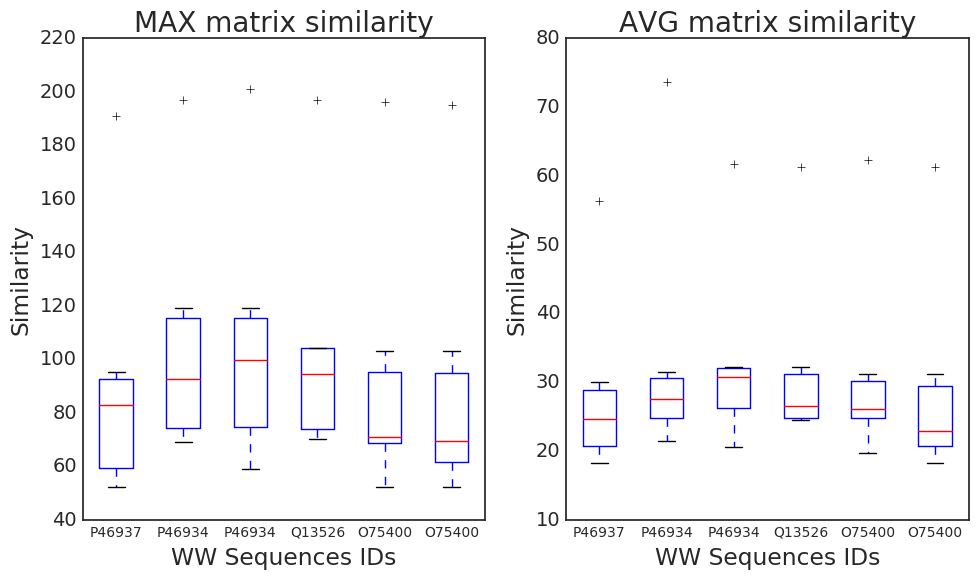

In [240]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-white')
plt.rcParams['xtick.labelsize'] = 10

width = 10
height = 6
plt.figure(figsize=(width, height), dpi=400)

seq_ids = [seq_record_i.id.split("|")[1] for seq_record_i in SeqIO.parse("../data/WW-sequence.fasta", "fasta")]
plt.subplot(121)
plt.boxplot(max_score_matrix)
plt.xticks(range(1, 7), seq_ids)
plt.ylabel("Similarity")
plt.xlabel("WW Sequences IDs")
plt.title("MAX matrix similarity")

plt.subplot(122)
plt.boxplot(avg_score_matrix)
plt.xticks(range(1, 7), seq_ids)
plt.ylabel("Similarity")
plt.xlabel("WW Sequences IDs")
plt.title("AVG matrix similarity")

plt.tight_layout()

plt.show()

From the first box-plot, it seems again that the second and third have higher scores, while the last 2 do not align that well to the other sequences in our file.  
The second boxplot doesn't show large differences tough, not as much as the first one.

Out of curiosity, let's perform on the third and sixth sequences a [T-test](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.ttest_rel.html) for related populations, to check if, despite the few observations at our disposal, it is possible to say that one has higher average alignment score than the other.  
Note that the T-test works only under certain assumptions, which might not be satisfied in our case: in particular, it assumes that our sampl

In [248]:
from scipy import stats

scipy.stats.ttest_ind(max_score_matrix[2,:], max_score_matrix[5,:])

ValueError: skewtest is not valid with less than 8 samples; 6 samples were given.

With a p-value of $0.6$, we cannot really reject the hypothesis that the 2 populations have the same mean!